In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
class GaussianiBandit:
    def __init__(self, n_arms, means=None, stds=None):
        self.n_arms = n_arms
        self.means = means  # e.g. np.array of shape (n_arms,)
        self.stds = stds  # e.g. sigma_i = mu_i/2
        self.optimal_arm = np.argmax(self.means)
    
    def pull(self, action):
        # Gaussian reward
        return np.random.normal(loc=self.means[action], scale=self.stds[action])
    
    def optimal_value(self):
        return self.means[self.optimal_arm]


class UCBmixLCB:
    """
    A variance-aware bandit agent that
      1) Starts with a UCB-like approach (variance-based).
      2) Monitors realized deviation from expected rewards.
      3) Switches to LCB or Greedy if negative deviation is too large.
    """
    def __init__(self, n_arms, alpha_op=2.0, alpha_pe=2.0, switch_threshold=-10.0, T=50000, mode='ucb', switch_lcb=False):
        """
        :param n_arms: Number of arms.
        :param alpha_op: Exploration factor for UCB (optimistic).
        :param alpha_pe: Exploration factor for LCB (pessimistic).
        :param switch_threshold: If cumulative deviation goes below this, we switch to LCB mode.
        """
        self.n_arms = n_arms
        self.alpha_op = alpha_op
        self.alpha_pe = alpha_pe
        self.switch_lcb = switch_lcb
        self.switch_threshold = switch_threshold
        self.T = T
        
        # Counts for each arm
        self.counts = np.zeros(n_arms, dtype=np.int64)
        
        # Running mean for each arm
        self.means = np.zeros(n_arms, dtype=np.float64)
        
        # M2 accumulator for each arm (for variance)
        self.M2 = np.zeros(n_arms, dtype=np.float64)
        
        # Keep track of total pulls
        self.t = 0
        
        # Track cumulative deviation = sum_{t} [reward - predicted_mean]
        # You can define "predicted_mean" in different ways.
        self.cumulative_deviation = 0.0
        
        # Mode: "ucb" or "lcb" or "greedy"
        self.mode = mode
    
    def _variance(self, i):
        """Return sample variance for arm i."""
        if self.counts[i] <= 1:
            return 1.0  # fallback if not enough data
        return self.M2[i] / (self.counts[i] - 1)
    
    def select_arm(self):
        """
        Decide which arm to pull, depending on the mode (UCB or LCB).
        You can also do more complex logic if desired.
        """
        if self.mode == "ucb":
            # UCB = mean + alpha_op * sqrt(var / n)
            ucb_values = []
            for i in range(self.n_arms):
                var_i = self._variance(i)
                bonus = self.alpha_op * np.sqrt(var_i / (self.counts[i] + 1e-9))
                ucb_values.append(self.means[i] + bonus)
            return np.argmax(ucb_values)
        
        elif self.mode == "lcb":
            # LCB = mean - alpha_pe * sqrt(var / n)
            # (some arms might have 0 or negative, but we want the highest LCB)
            lcb_values = []
            for i in range(self.n_arms):
                var_i = self._variance(i)
                penalty = self.alpha_pe * np.sqrt(2 / (self.counts[i] + 1e-9))
                lcb_values.append(self.means[i] - penalty)
            return np.argmax(lcb_values)
        
        elif self.mode == "vanilla":
            ucb_values = []
            for i in range(self.n_arms):
                bonus = self.alpha_op * np.sqrt(2 * np.log(self.t) / (self.counts[i] + 1e-9))
                ucb_values.append(self.means[i] + bonus)
            return np.argmax(ucb_values)
        
        else:  # "greedy"
            # Just pick arm with highest estimated mean
            return np.argmax(self.means)
    
    def update(self, action, reward):
        """
        Update the mean, variance, and possibly switch modes
        based on realized deviation.
        """
        self.t += 1
        
        # Old mean for computing deviation
        old_mean = self.means[action]
        
        # Welford’s algorithm: update counts, means, M2
        self.counts[action] += 1
        n = self.counts[action]
        
        delta = reward - old_mean
        self.means[action] += delta / n
        self.M2[action] += delta * (reward - self.means[action])
        
        # Optionally track deviation:
        # e.g. deviation = (reward - old_mean), or reward - self.means[action], etc.
        # We'll do (reward - old_mean) here:
        self.cumulative_deviation += (reward - old_mean)
        
        # Check if we cross threshold => switch to LCB
        if self.mode != "lcb" and self.switch_lcb and self.cumulative_deviation < self.switch_threshold:
                print(f'Switched to LCB at timestep {self.t}')
                self.mode = "lcb"
        '''
        if self.t > self.T - np.sqrt(self.T):
            self.mode = 'greedy'
        '''
        # Alternatively, if we near the horizon or are confident, switch to "greedy"
        # (You can add your own condition, e.g., a certain time t > T/2, etc.)

    def print_status(self):
        print(f"Mode: {self.mode}")
        # print(f"Counts: {self.counts}")
        # print(f"Means: {self.means}")
        # print(f"M2: {self.M2}")
        print(f"Cumulative Deviation: {self.cumulative_deviation}\n")


In [7]:
def mab_simulation(bandit, alpha_op, alpha_pe, n_arms, n_iter, n_experiments, switch_threshold, mode, switch_lcb):
    joint_rewards = np.zeros((n_experiments, n_iter))
    for e in range(n_experiments):
        agent = UCBmixLCB(n_arms, alpha_op, alpha_pe, switch_threshold, n_iter, mode, switch_lcb)
        for i in range(n_iter):
            action = agent.select_arm()
            reward = bandit.pull(action)
            agent.update(action, reward)
            joint_rewards[e, i] = reward
            if (i + 1) % 10000 == 0:
                print(f'running experiment {e}, iteration {i + 1}')
                agent.print_status()
    cum_rewards = np.cumsum(joint_rewards, axis=1)
    cum_rewards_mean = np.mean(cum_rewards, axis=0)
    cum_rewards_std = np.std(cum_rewards, axis=0)
    return cum_rewards_mean, cum_rewards_std

In [8]:
seed = 0
np.random.seed(seed)
n_arms = 100
means = np.random.rand(n_arms)
# bound the means to [0.1, 0.9]
means = np.maximum(means, 0.05)
means = np.minimum(means, 0.95)
means[50] = 0.99
stds = [1] * n_arms
switch_threshold = -50.0 # difference between expected and cumulative reward
bandit = GaussianiBandit(n_arms, means, stds)

In [9]:
alpha_op = 1
alpha_pe = .9
n_iter = 100000
n_experiments = 10

In [10]:
r_ucb, v_ucb = mab_simulation(bandit=bandit, alpha_op=alpha_op, alpha_pe=alpha_pe, n_arms=n_arms, n_iter=n_iter, n_experiments=n_experiments, switch_threshold=-100, mode='ucb', switch_lcb=False)


running experiment 0, iteration 10000
Mode: ucb
Cumulative Deviation: -262.40568547339615

running experiment 0, iteration 20000
Mode: ucb
Cumulative Deviation: -90.36764098617135

running experiment 0, iteration 30000
Mode: ucb
Cumulative Deviation: -156.96789567620803

running experiment 0, iteration 40000
Mode: ucb
Cumulative Deviation: -147.7238743961127

running experiment 0, iteration 50000
Mode: ucb
Cumulative Deviation: -169.68675835175358

running experiment 0, iteration 60000
Mode: ucb
Cumulative Deviation: -100.70722808222462

running experiment 0, iteration 70000
Mode: ucb
Cumulative Deviation: -209.50038133659666

running experiment 0, iteration 80000
Mode: ucb
Cumulative Deviation: -78.0979697902881

running experiment 0, iteration 90000
Mode: ucb
Cumulative Deviation: 81.96816439020571

running experiment 0, iteration 100000
Mode: ucb
Cumulative Deviation: 247.79021002504382

running experiment 1, iteration 10000
Mode: ucb
Cumulative Deviation: -412.0287205420614

runnin

In [13]:
r_mix, v_mix = mab_simulation(bandit=bandit, alpha_op=alpha_op, alpha_pe=alpha_pe, n_arms=n_arms, n_iter=n_iter, n_experiments=n_experiments, switch_threshold=-300, mode='ucb', switch_lcb=True)

Switched to LCB at timestep 7046
running experiment 0, iteration 10000
Mode: lcb
Cumulative Deviation: -300.1188150307922

running experiment 0, iteration 20000
Mode: lcb
Cumulative Deviation: -397.1687688057043

running experiment 0, iteration 30000
Mode: lcb
Cumulative Deviation: -304.61796286435776

running experiment 0, iteration 40000
Mode: lcb
Cumulative Deviation: -476.3464098755444

running experiment 0, iteration 50000
Mode: lcb
Cumulative Deviation: -384.56984446387446

running experiment 0, iteration 60000
Mode: lcb
Cumulative Deviation: -251.91274716272196

running experiment 0, iteration 70000
Mode: lcb
Cumulative Deviation: -393.530334064486

running experiment 0, iteration 80000
Mode: lcb
Cumulative Deviation: -378.70847810491557

running experiment 0, iteration 90000
Mode: lcb
Cumulative Deviation: -423.7813360376454

running experiment 0, iteration 100000
Mode: lcb
Cumulative Deviation: -291.3279189787524

Switched to LCB at timestep 2940
running experiment 1, iteratio

In [14]:
r_vanilla, v_vanilla = mab_simulation(bandit=bandit, alpha_op=alpha_op, alpha_pe=alpha_pe, n_arms=n_arms, n_iter=n_iter, n_experiments=n_experiments, switch_threshold=-100, mode='vanilla', switch_lcb=False)

/var/folders/39/5w_n98y523q5v9f1rhz5n9y00000gn/T/ipykernel_41076/64160381.py:89: RuntimeWarning: divide by zero encountered in log
  bonus = self.alpha_op * np.sqrt(2 * np.log(self.t) / (self.counts[i] + 1e-9))
/var/folders/39/5w_n98y523q5v9f1rhz5n9y00000gn/T/ipykernel_41076/64160381.py:89: RuntimeWarning: invalid value encountered in sqrt
  bonus = self.alpha_op * np.sqrt(2 * np.log(self.t) / (self.counts[i] + 1e-9))


running experiment 0, iteration 10000
Mode: vanilla
Cumulative Deviation: -316.9206791640614

running experiment 0, iteration 20000
Mode: vanilla
Cumulative Deviation: -534.016968314382

running experiment 0, iteration 30000
Mode: vanilla
Cumulative Deviation: -463.19581919559727

running experiment 0, iteration 40000
Mode: vanilla
Cumulative Deviation: -446.2637961712969

running experiment 0, iteration 50000
Mode: vanilla
Cumulative Deviation: -394.29310622236244

running experiment 0, iteration 60000
Mode: vanilla
Cumulative Deviation: -357.0579648926151

running experiment 0, iteration 70000
Mode: vanilla
Cumulative Deviation: -343.72955477042615

running experiment 0, iteration 80000
Mode: vanilla
Cumulative Deviation: -296.8509933935469

running experiment 0, iteration 90000
Mode: vanilla
Cumulative Deviation: -166.3048469366726

running experiment 0, iteration 100000
Mode: vanilla
Cumulative Deviation: -211.13201940845147

running experiment 1, iteration 10000
Mode: vanilla
Cumu

In [15]:
r_greedy, v_greedy = mab_simulation(bandit=bandit, alpha_op=alpha_op, alpha_pe=alpha_pe, n_arms=n_arms, n_iter=n_iter, n_experiments=n_experiments, switch_threshold=-100, mode='greedy', switch_lcb=False)
r_lcb, v_lcb = mab_simulation(bandit=bandit, alpha_op=alpha_op, alpha_pe=alpha_pe, n_arms=n_arms, n_iter=n_iter, n_experiments=n_experiments, switch_threshold=-100, mode='lcb', switch_lcb=False)

running experiment 0, iteration 10000
Mode: greedy
Cumulative Deviation: -41.197521262124425

running experiment 0, iteration 20000
Mode: greedy
Cumulative Deviation: 45.67839030450573

running experiment 0, iteration 30000
Mode: greedy
Cumulative Deviation: 85.28710233109003

running experiment 0, iteration 40000
Mode: greedy
Cumulative Deviation: 101.87349862367331

running experiment 0, iteration 50000
Mode: greedy
Cumulative Deviation: 82.19817568248911

running experiment 0, iteration 60000
Mode: greedy
Cumulative Deviation: 110.08449320703288

running experiment 0, iteration 70000
Mode: greedy
Cumulative Deviation: 178.45174104297422

running experiment 0, iteration 80000
Mode: greedy
Cumulative Deviation: 121.15573211474262

running experiment 0, iteration 90000
Mode: greedy
Cumulative Deviation: -15.725212515517995

running experiment 0, iteration 100000
Mode: greedy
Cumulative Deviation: 114.33331703402459

running experiment 1, iteration 10000
Mode: greedy
Cumulative Deviatio

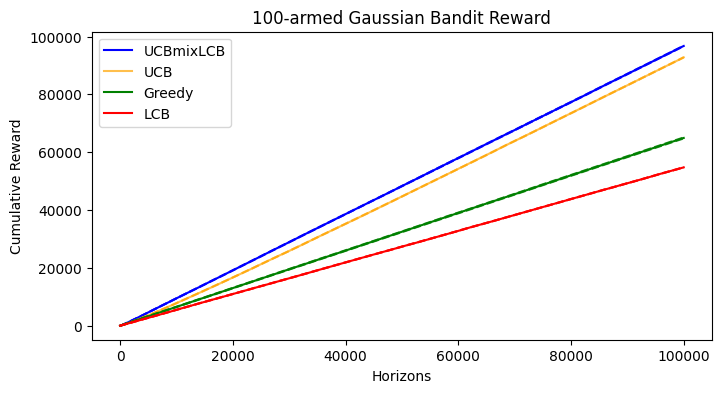

In [17]:
ci_multiplier = 1.96
x = np.arange(len(r_greedy))  # Assuming the x-axis represents iterations

# Calculate standard error and confidence interval for Greedy
se_greedy = np.sqrt(v_greedy)
lower_greedy = r_greedy - ci_multiplier * se_greedy
upper_greedy = r_greedy + ci_multiplier * se_greedy

# Calculate standard error and confidence interval for LCB
se_lcb = np.sqrt(v_lcb)
lower_lcb = r_lcb - ci_multiplier * se_lcb
upper_lcb = r_lcb + ci_multiplier * se_lcb

se_vanilla = np.sqrt(v_vanilla)
lower_vanilla = r_vanilla - ci_multiplier * se_vanilla
upper_vanilla = r_vanilla + ci_multiplier * se_vanilla

se_mix = np.sqrt(v_mix)
lower_mix = r_mix - ci_multiplier * se_mix
upper_mix = r_mix + ci_multiplier * se_mix



plt.figure(figsize=(8, 4))

plt.plot(r_mix, color='blue', label='UCBmixLCB')
plt.plot(lower_mix, color='blue', linestyle='--', alpha=.8)
plt.plot(upper_mix, color='blue', linestyle='--', alpha=.8)

plt.plot(r_vanilla, color='orange', label='UCB', alpha=.7)
plt.plot(lower_vanilla, color='orange', linestyle='--', alpha=0.5)
plt.plot(upper_vanilla, color='orange', linestyle='--', alpha=0.5)


plt.plot(r_greedy, color='g', label='Greedy')
plt.plot(lower_greedy, color='g', linestyle='--', alpha=0.8)
plt.plot(upper_greedy, color='g', linestyle='--', alpha=0.8)

plt.plot(r_lcb, color='r', label='LCB')
plt.plot(lower_lcb, color='r', linestyle='--', alpha=0.8)
plt.plot(upper_lcb, color='r', linestyle='--', alpha=0.8)


plt.title('100-armed Gaussian Bandit Reward')
plt.xlabel('Horizons')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.show()

In [18]:
r_expected = [means[50] * (i + 1) for i in range(100000)]
reg_mix = r_expected - r_mix
reg_vanilla = r_expected - r_vanilla
reg_greedy = r_expected - r_greedy
reg_lcb = r_expected - r_lcb


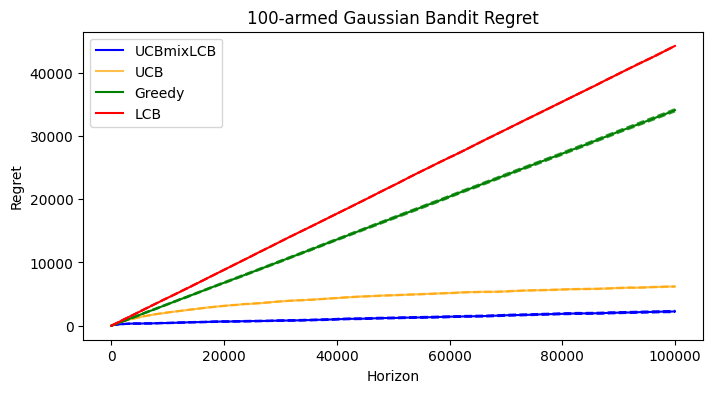

In [19]:
time = np.arange(1, 100000 + 1)
plt.figure(figsize=(8, 4))
scale = np.sqrt(time * np.log(time))
plt.title('100-armed Gaussian Bandit Regret')
plt.plot(reg_mix, color='blue', label='UCBmixLCB')
plt.plot(r_expected - lower_mix, color='blue', linestyle='--', alpha=1)
plt.plot(r_expected - upper_mix, color='blue', linestyle='--', alpha=1)


plt.plot(reg_vanilla, color='orange', label='UCB', alpha=.7)
plt.plot(r_expected - lower_vanilla, color='orange', linestyle='--', alpha=0.5)
plt.plot(r_expected - upper_vanilla, color='orange', linestyle='--', alpha=0.5)


plt.plot(reg_greedy, color='g', label='Greedy')
plt.plot(r_expected - lower_greedy, color='g', linestyle='--', alpha=0.8)
plt.plot(r_expected - upper_greedy, color='g', linestyle='--', alpha=0.8)

plt.plot(reg_lcb, color='r', label='LCB')
plt.plot(r_expected - lower_lcb, color='r', linestyle='--', alpha=0.8)
plt.plot(r_expected - upper_lcb, color='r', linestyle='--', alpha=0.8)


plt.legend()
plt.xlabel('Horizon')
plt.ylabel('Regret')
plt.show()

/var/folders/39/5w_n98y523q5v9f1rhz5n9y00000gn/T/ipykernel_31609/1905994818.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(reg_mix / scale, label='mix')
/var/folders/39/5w_n98y523q5v9f1rhz5n9y00000gn/T/ipykernel_31609/1905994818.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(reg_vanilla / scale, label='vanilla')
/var/folders/39/5w_n98y523q5v9f1rhz5n9y00000gn/T/ipykernel_31609/1905994818.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.plot(reg_lcb / scale, label='lcb')
/var/folders/39/5w_n98y523q5v9f1rhz5n9y00000gn/T/ipykernel_31609/1905994818.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.plot(reg_greedy / scale,label='greedy')


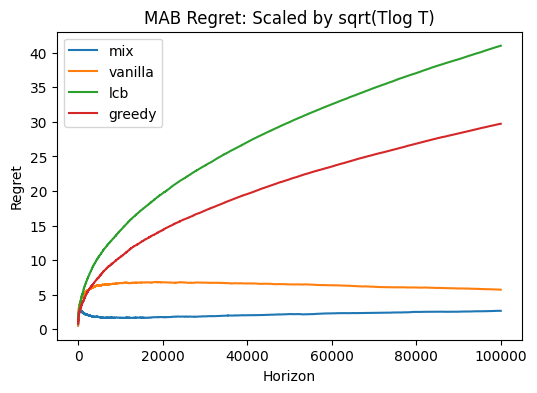

In [224]:
time = np.arange(1, 100000 + 1)
plt.figure(figsize=(6, 4))
scale = np.sqrt(time * np.log(time))
plt.title('MAB Regret: Scaled by sqrt(Tlog T)')
plt.plot(reg_mix / scale, label='mix')
plt.plot(reg_vanilla / scale, label='vanilla')
plt.plot(reg_lcb / scale, label='lcb')
plt.plot(reg_greedy / scale,label='greedy')
plt.legend()
plt.xlabel('Horizon')
plt.ylabel('Regret')
plt.show()

deviation-mean ratio